In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from res.plot_lib import set_default

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label='', count=False, energy=None):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            c = 4 * N + i
            if count: plt.title(str(c), color='w')
            if count and energy is not None: plt.title(f'{c}, e={energy[c].item():.2f}', color='w')


In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
# Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder generates mu and sigma
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, y):
        # encoder generates mu and log var
        mu_logvar = self.encoder(y.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [7]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(ỹ, y, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        ỹ, y.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Test set loss: 544.4362
====> Epoch: 1 Average loss: 191.1290
====> Test set loss: 137.1136
====> Epoch: 2 Average loss: 133.1030
====> Test set loss: 116.4854
====> Epoch: 3 Average loss: 121.1020
====> Test set loss: 109.1143
====> Epoch: 4 Average loss: 116.0829
====> Test set loss: 105.3982
====> Epoch: 5 Average loss: 113.3734
====> Test set loss: 103.6147
====> Epoch: 6 Average loss: 111.5552
====> Test set loss: 101.3753
====> Epoch: 7 Average loss: 110.2741
====> Test set loss: 100.2388
====> Epoch: 8 Average loss: 109.3209
====> Test set loss: 99.5458
====> Epoch: 9 Average loss: 108.4819
====> Test set loss: 98.1383
====> Epoch: 10 Average loss: 107.8582
====> Test set loss: 98.0818


C:\Users\22718\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


====> Epoch: 11 Average loss: 107.3405
====> Test set loss: 98.0845
====> Epoch: 12 Average loss: 106.9310
====> Test set loss: 97.8316
====> Epoch: 13 Average loss: 106.5244
====> Test set loss: 97.6765
====> Epoch: 14 Average loss: 106.2231
====> Test set loss: 97.0041
====> Epoch: 15 Average loss: 105.9225
====> Test set loss: 96.8061
====> Epoch: 16 Average loss: 105.7353
====> Test set loss: 96.7605
====> Epoch: 17 Average loss: 105.4016
====> Test set loss: 96.3286
====> Epoch: 18 Average loss: 105.1865
====> Test set loss: 96.2847
====> Epoch: 19 Average loss: 104.9606
====> Test set loss: 95.7668
====> Epoch: 20 Average loss: 104.7842
====> Test set loss: 95.9326


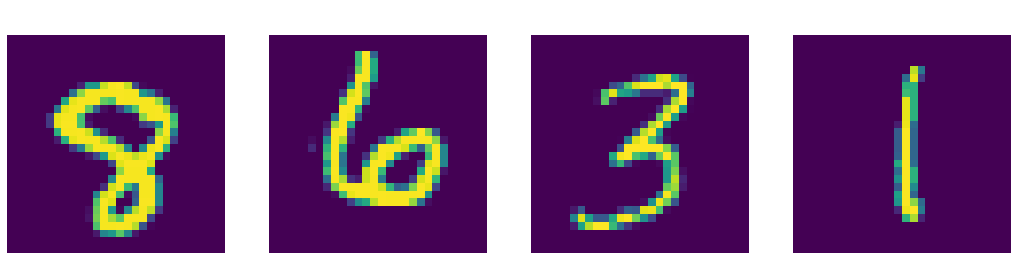

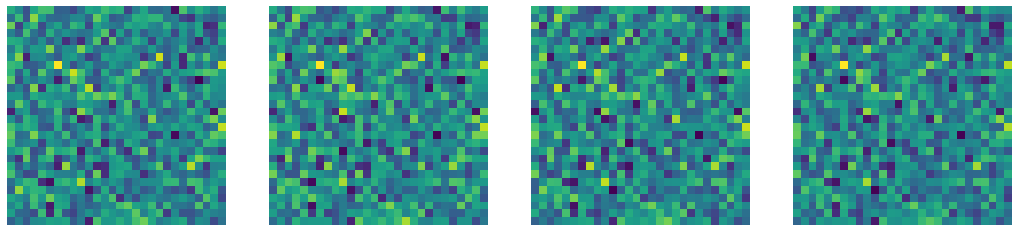

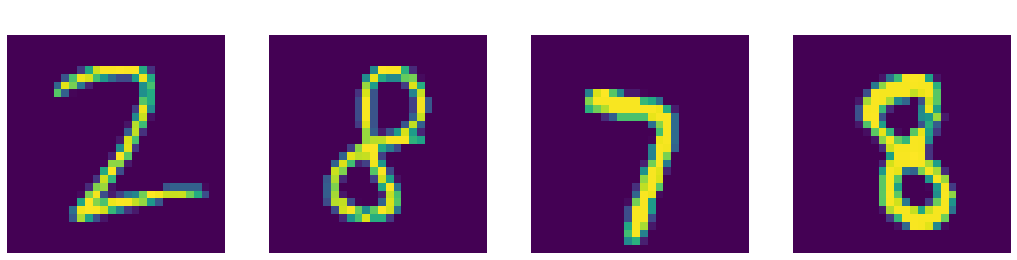

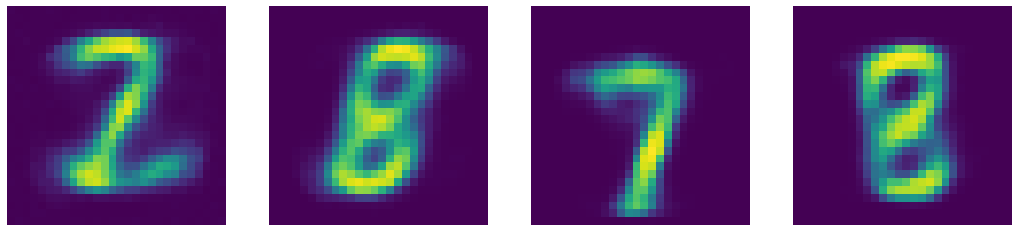

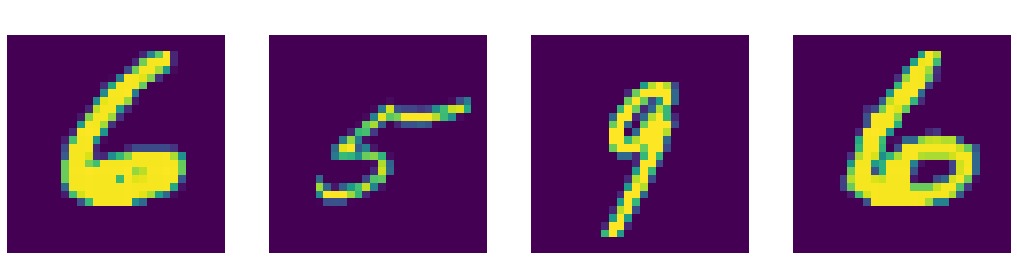

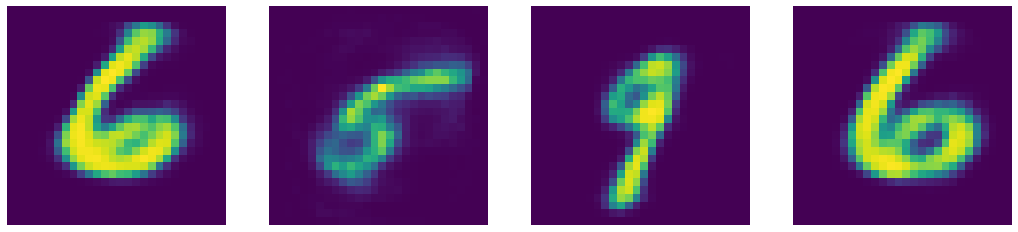

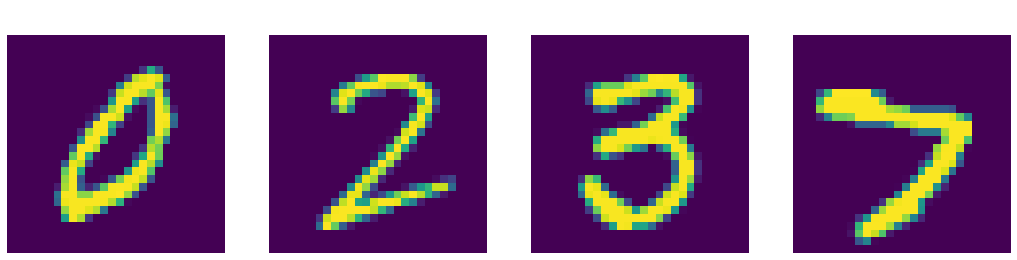

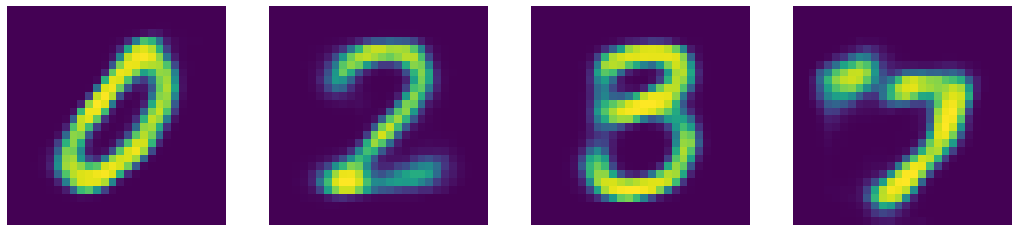

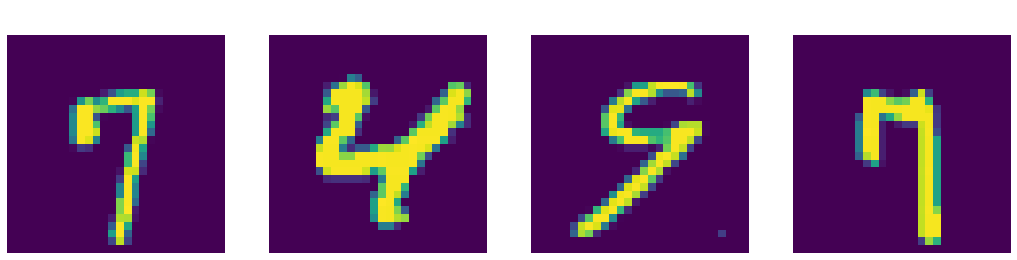

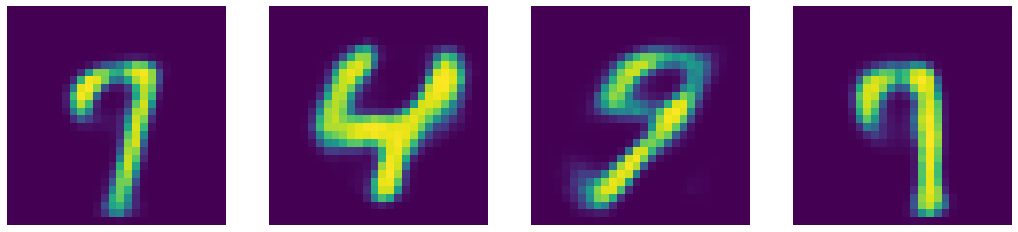

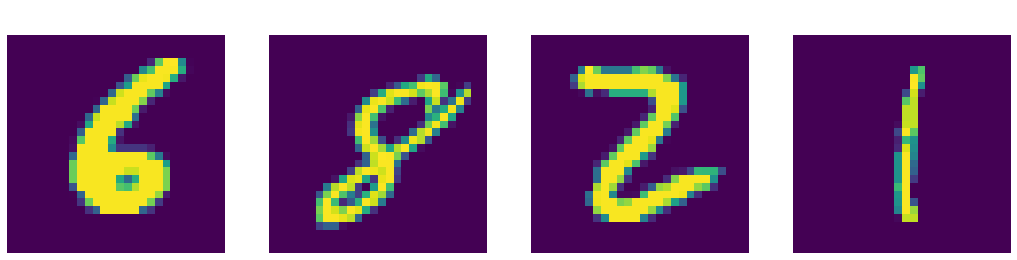

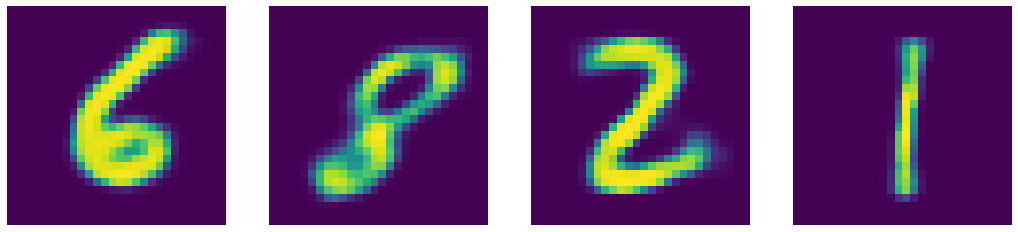

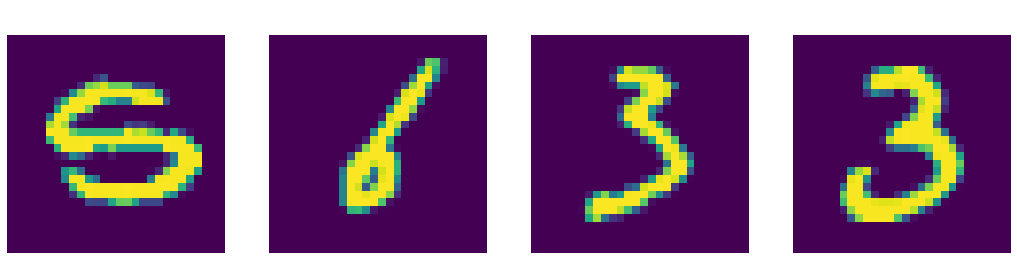

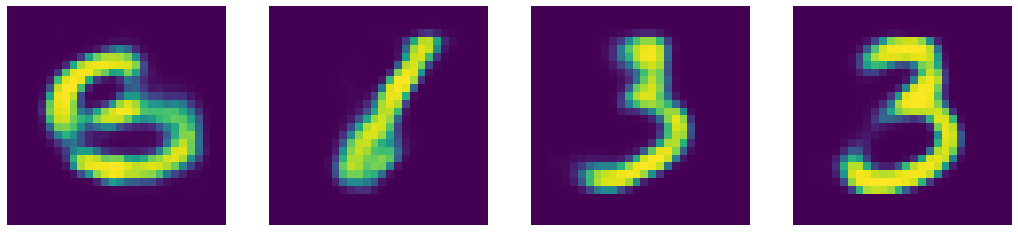

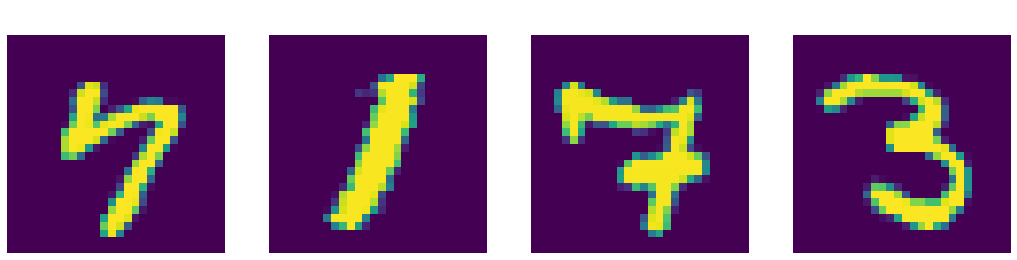

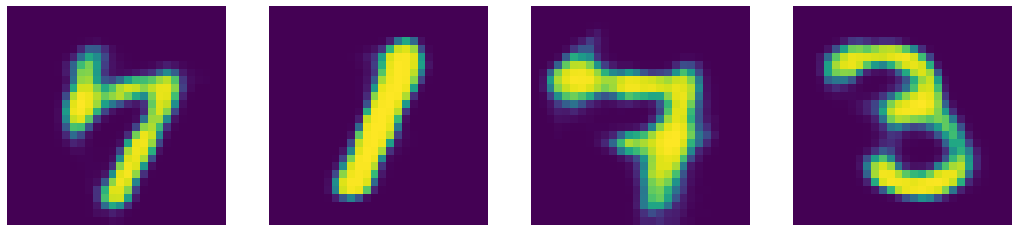

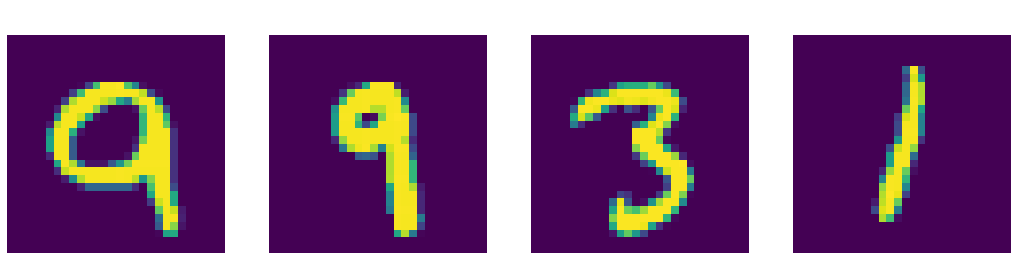

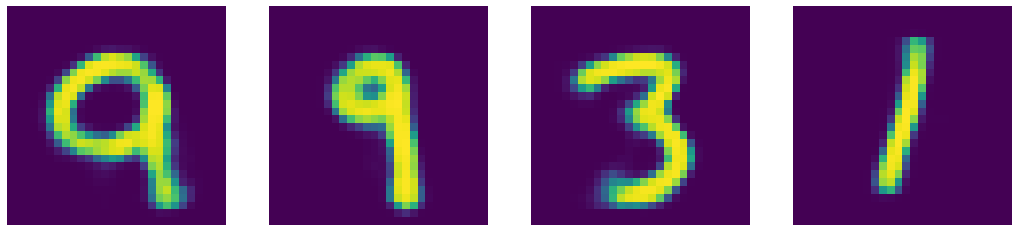

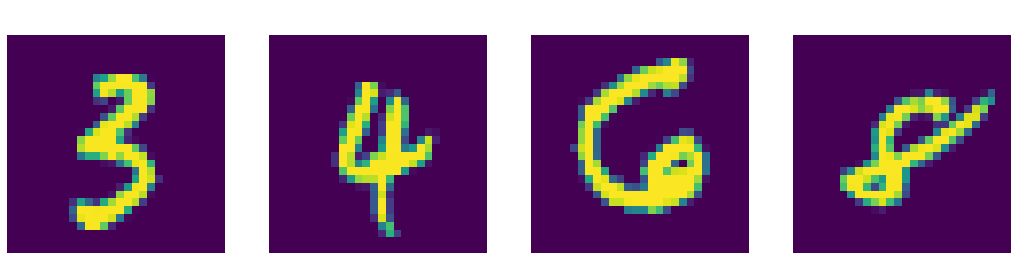

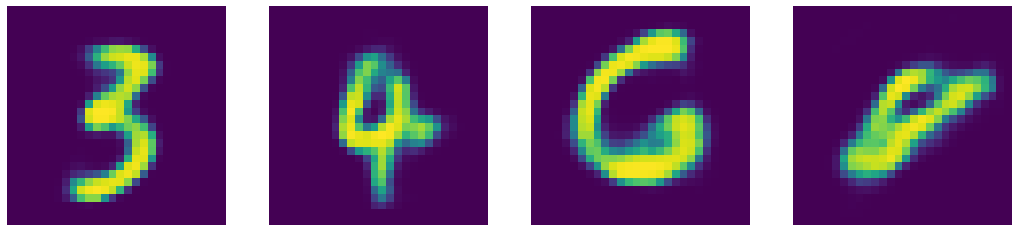

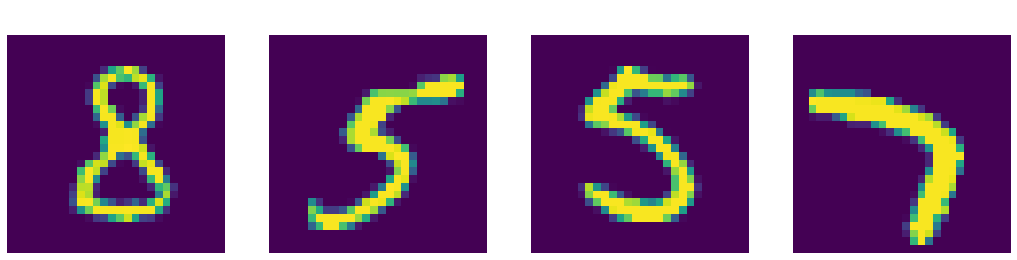

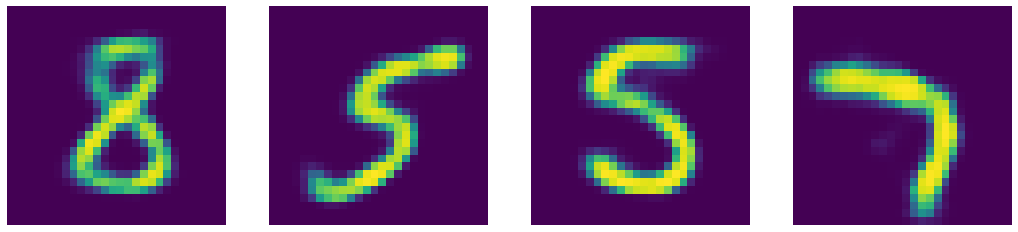

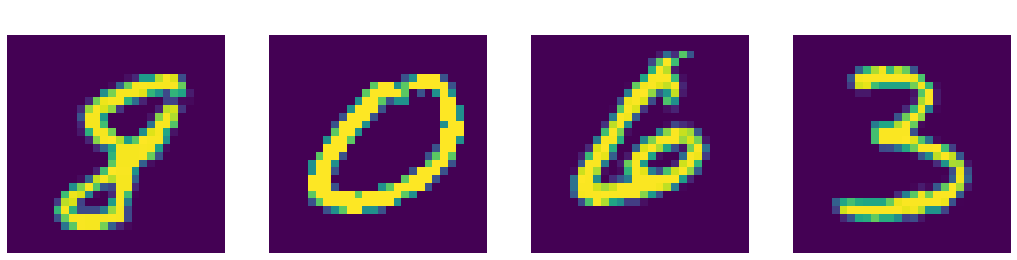

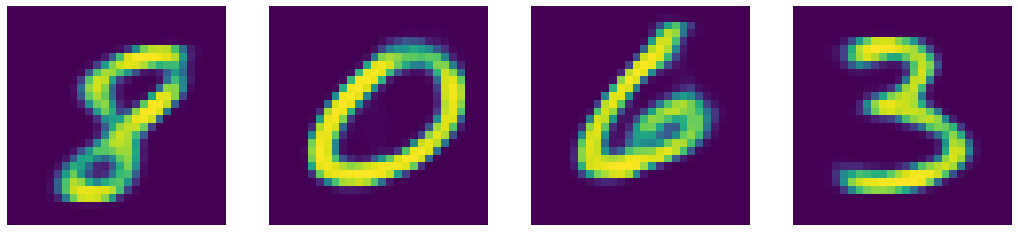

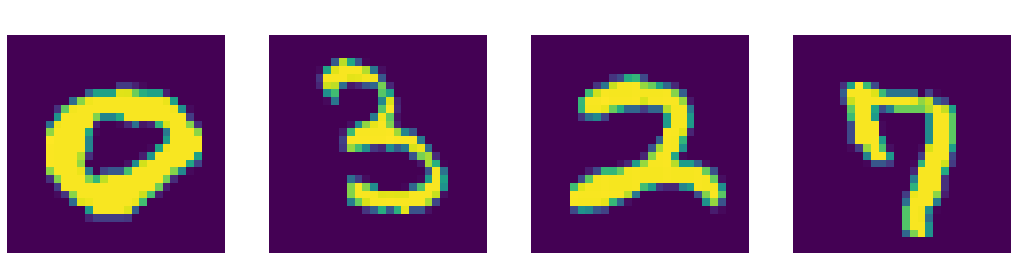

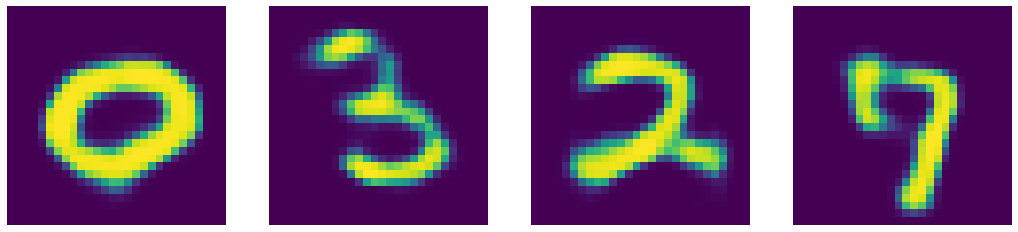

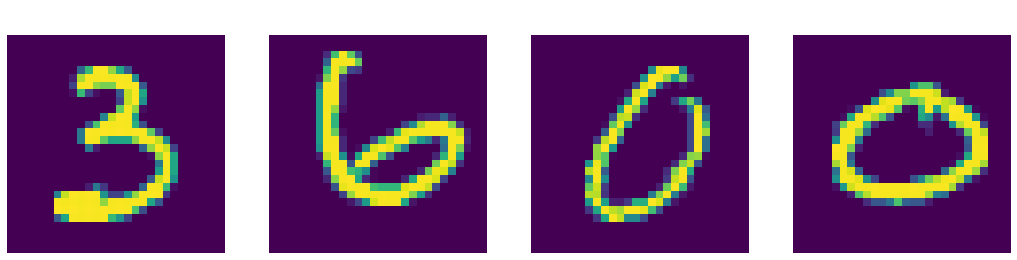

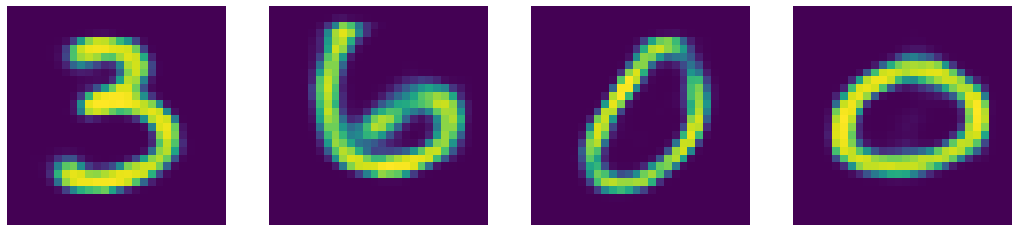

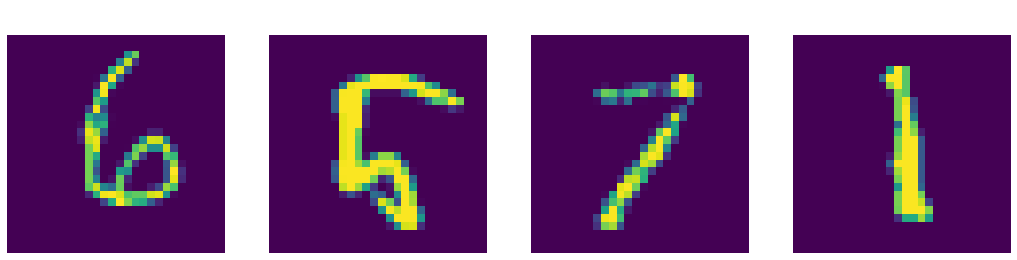

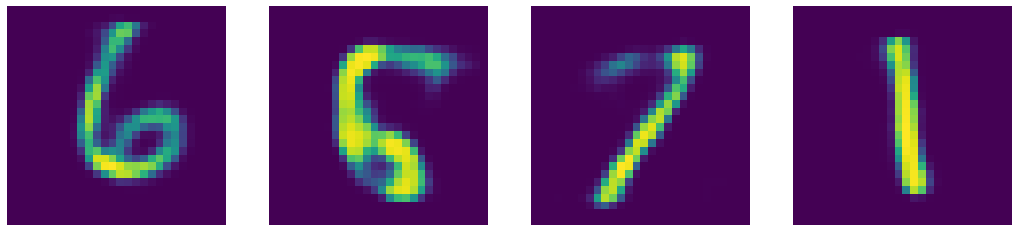

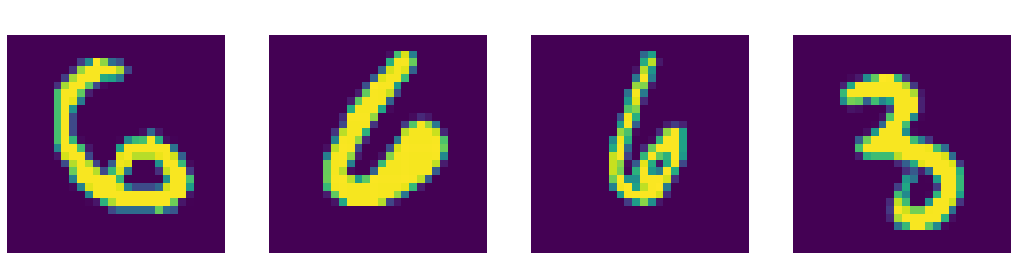

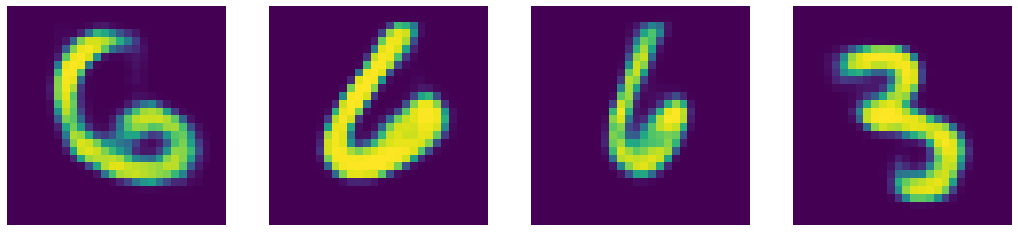

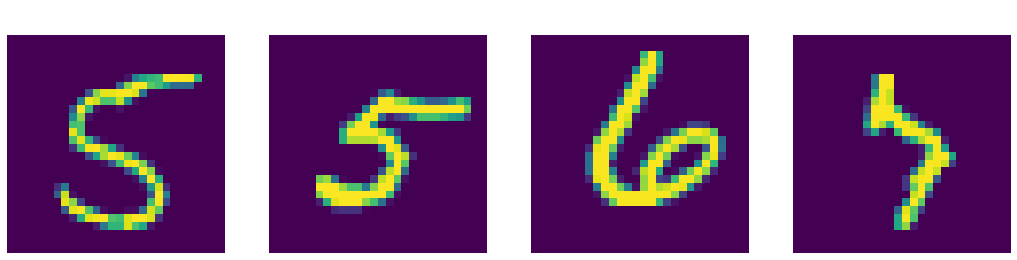

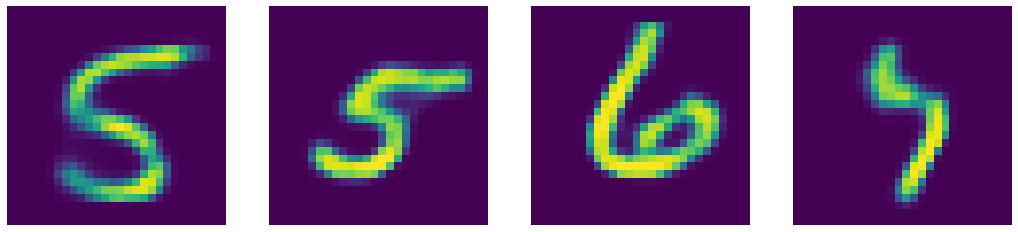

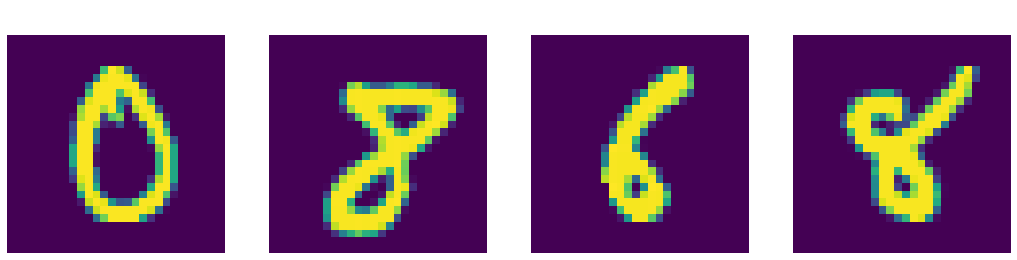

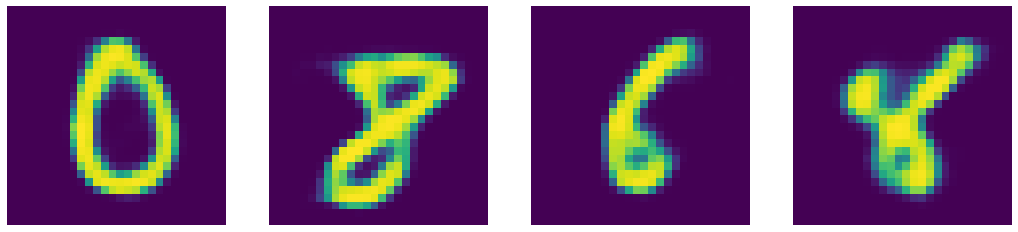

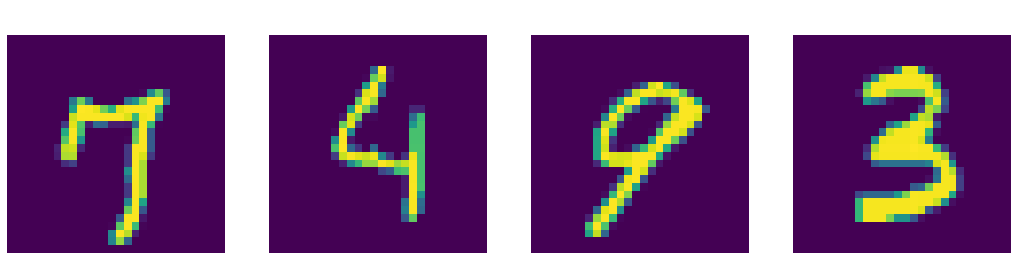

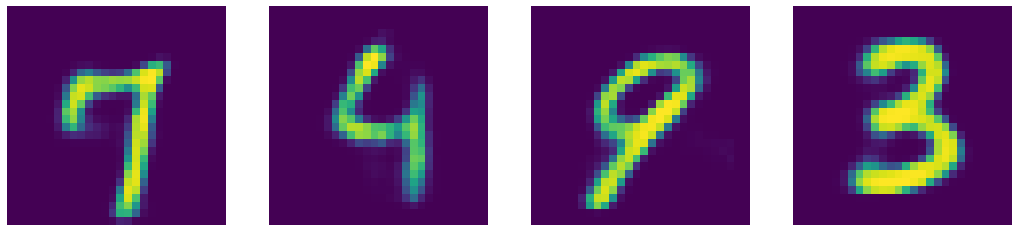

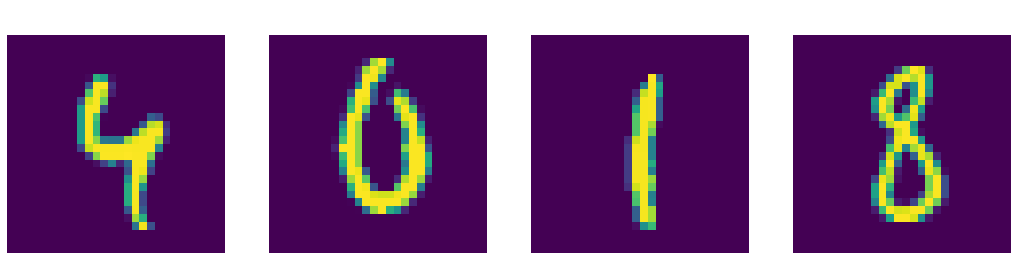

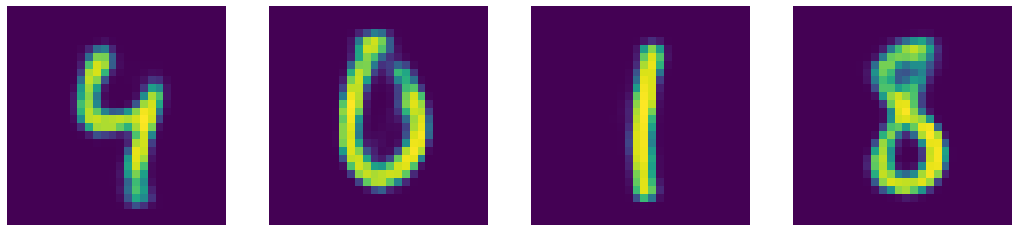

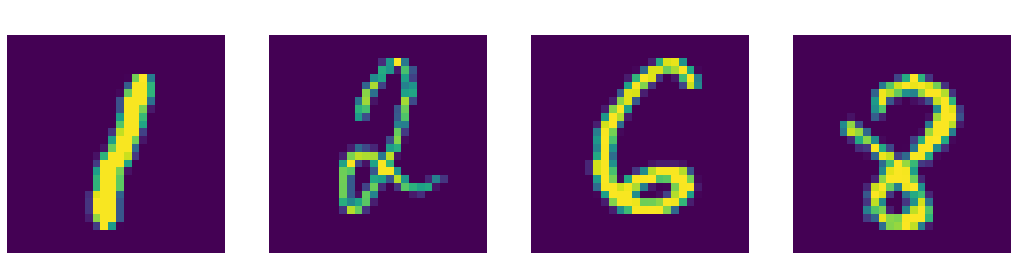

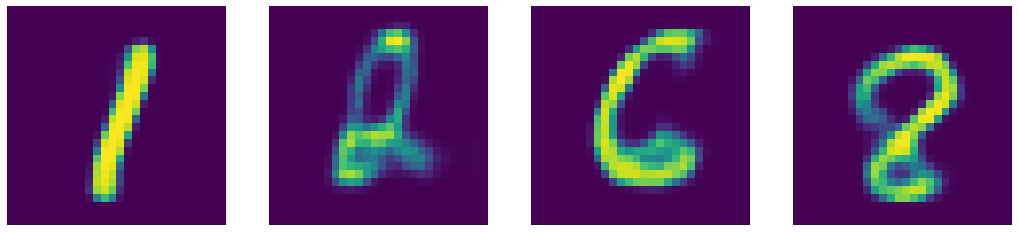

In [9]:
# Training and testing the VAE

epochs = 20
codes = dict(μ=list(), logσ2=list(), x=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for y, _ in train_loader:
            y = y.to(device)
            # ===================forward=====================
            ỹ, mu, logvar = model(y)
            loss = loss_function(ỹ, y, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for y, x in test_loader:
            y = y.to(device)
            # ===================forward=====================
            ỹ, mu, logvar = model(y)
            test_loss += loss_function(ỹ, y, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(x.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(y, ỹ, 1, f'Epoch {epoch}')

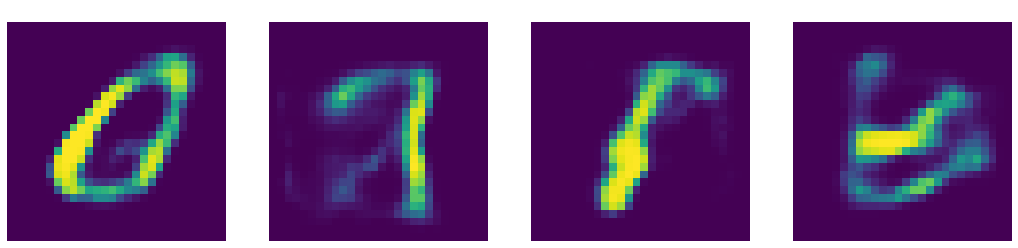

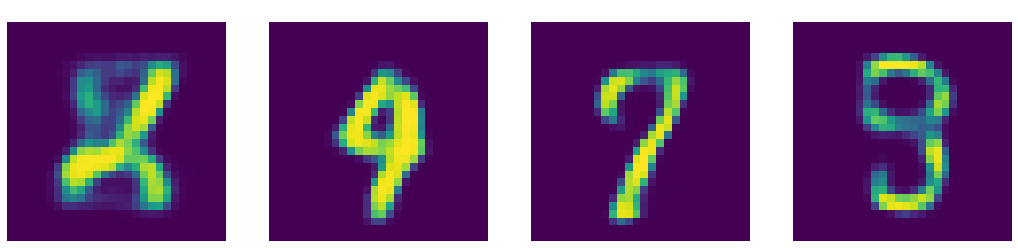

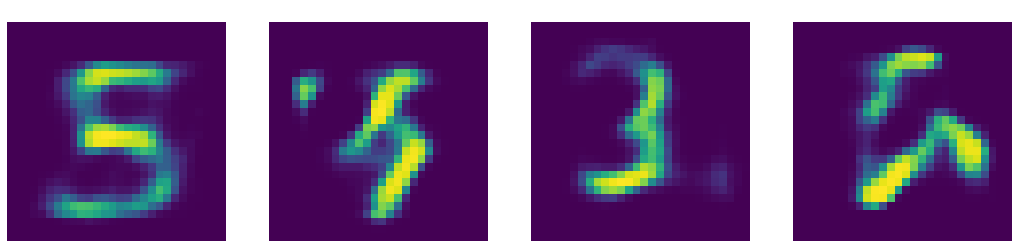

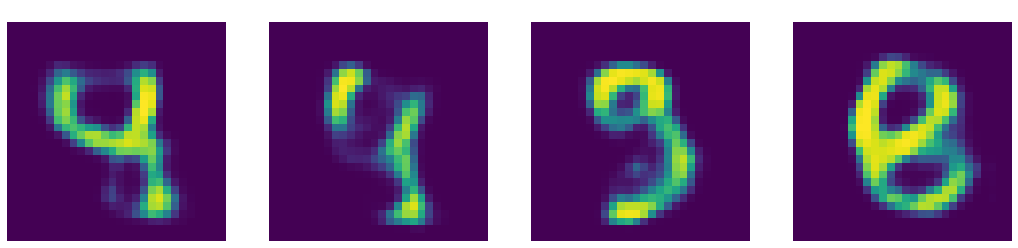

In [10]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

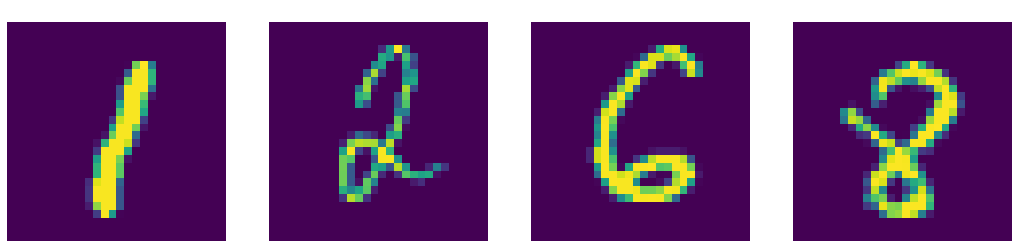

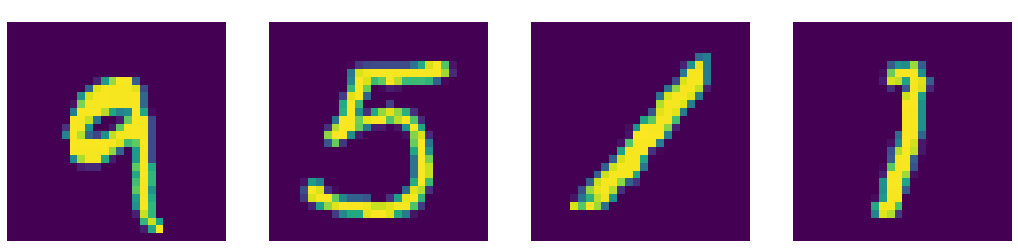

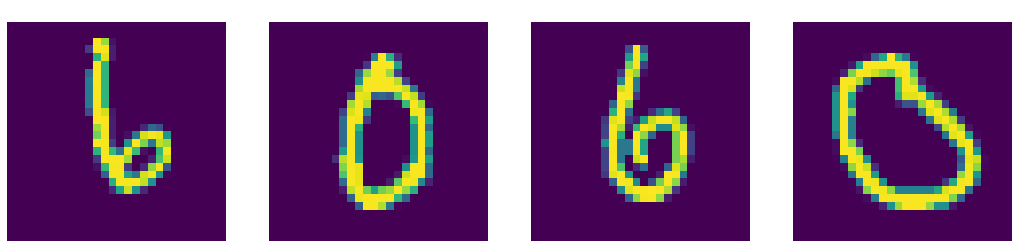

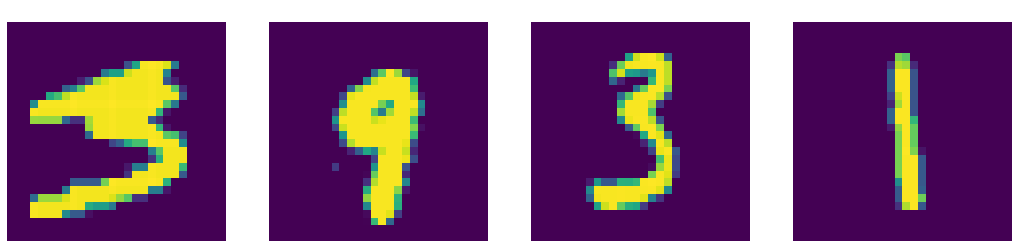

In [11]:
# Display last test batch
with torch.no_grad():
    ỹ = model(y)[0].view(-1, 28, 28)
energy = y.squeeze().sub(ỹ).pow(2).sum(dim=(1,2))
display_images(None, y, 4, count=True, energy=energy)

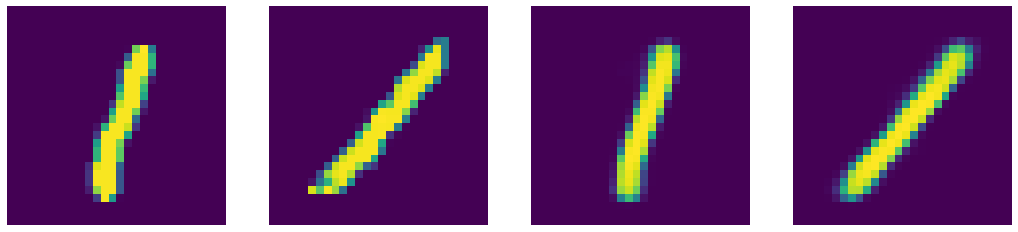

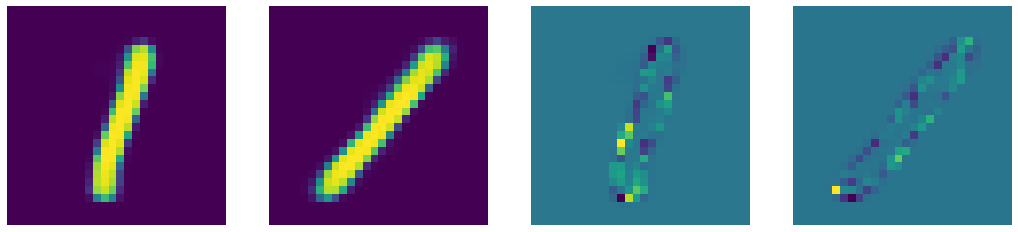

In [12]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 0, 6
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1],
    sample.data[0],
    sample.data[1],
    y[A].data.view(-1) - sample.data[0],
    y[B].data.view(-1) - sample.data[1]
)), 0), 2)

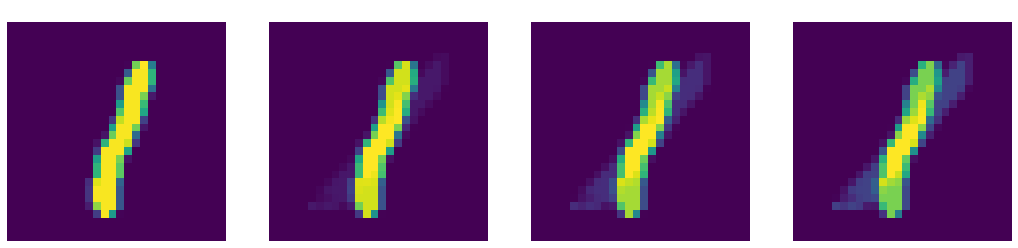

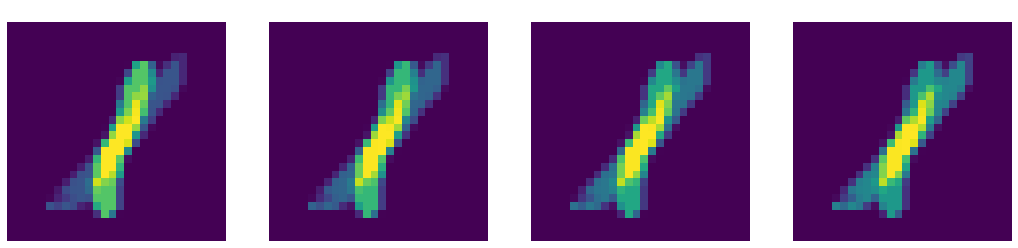

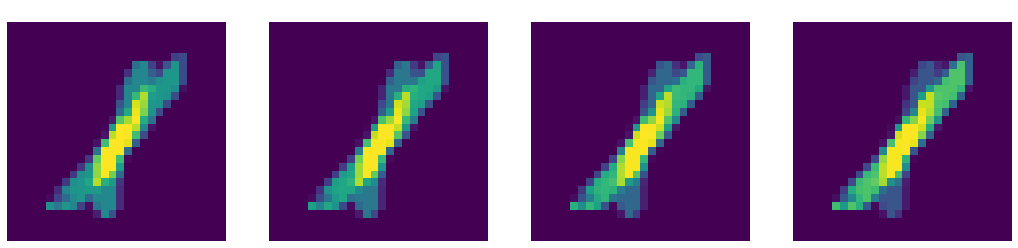

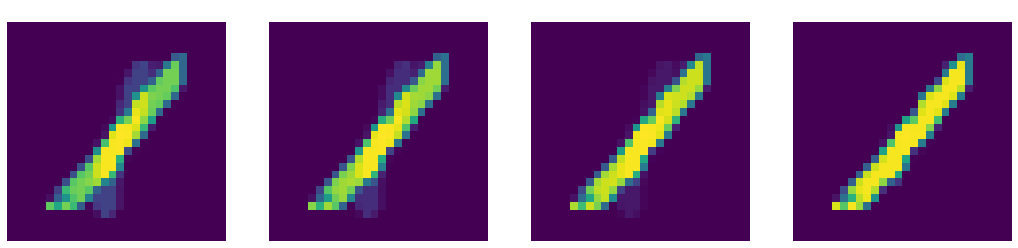

In [13]:
# Perform an interpolation between input A and B, in N steps

N = 16
# code = torch.Tensor(N, 20).to(device)
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    # code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
# samples = model.decoder(code)
display_images(None, samples, N // 4, count=True)

In [16]:
ẏ = sample[9]
with torch.no_grad():
    ỹ = model(ẏ)[0]
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((ẏ).view(28, 28))
plt.subplot(122), plt.imshow((ỹ).view(28, 28))

IndexError: index 9 is out of bounds for dimension 0 with size 2

In [17]:
N = 16
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
with torch.no_grad():
    reconstructions = model(samples)[0].view(-1, 28, 28)

plt.title(f'{A = }, {B = }')
plt.plot(samples.sub(reconstructions).pow(2).sum(dim=(1,2)), '-o')

SyntaxError: invalid syntax (<fstring>, line 1)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
set_default(figsize=(15, 4))

In [ ]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    Y.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1].detach().cpu()))
    X.append(codes['x'][epoch][:N])

In [ ]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=X[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)